# Домашнее задание №8

**Задания к курсу**
1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети

# Библиотеки

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

# Данные

In [2]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [4]:
BUFFER_SIZE = 200
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image


In [5]:
train_horses = train_horses.map(
    preprocess_image_train).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train).batch(1)

test_horses = test_horses.map(
    preprocess_image_test).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test).batch(1)

# Пример

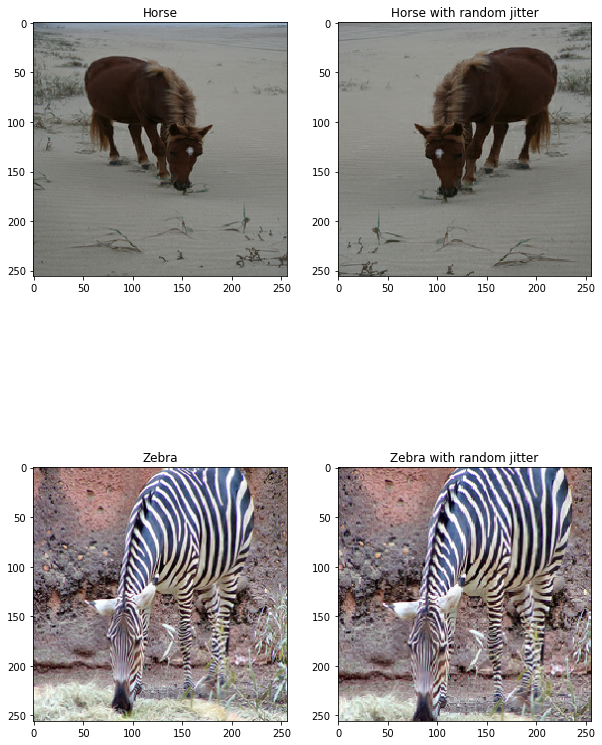

In [6]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

plt.subplots(figsize=(10, 15))

plt.subplot(221)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(222)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)
plt.subplot(223)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(224)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

# Модели

In [7]:
OUTPUT_CHANNELS = 3

generator_horse_to_zebra = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_zebra_to_horse = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_horse = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_zebra = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [13]:
generator_horse_to_zebra.layers

In [14]:
generator_horse_to_zebra.layers[2].layers

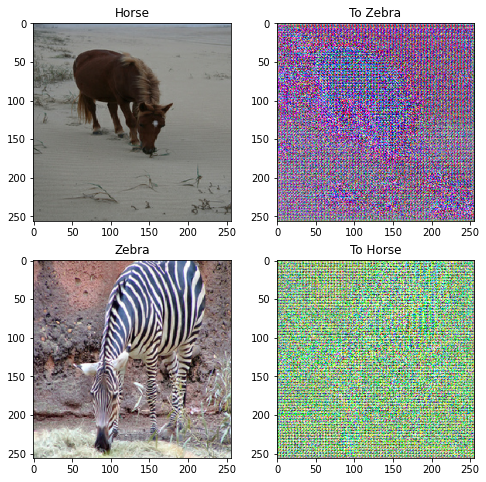

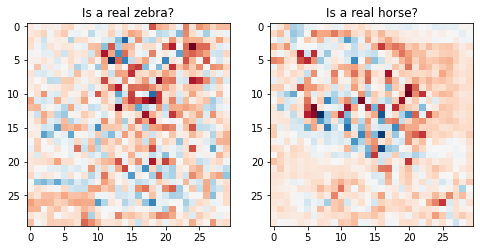

In [8]:
to_zebra = generator_horse_to_zebra(sample_horse)
to_horse = generator_zebra_to_horse(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_zebra(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_horse(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Функция потерь

In [9]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(discriminator_ans):
  return loss_obj(tf.ones_like(discriminator_ans), discriminator_ans)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

# Оптимизаторы для обучения

In [10]:
generator_horse_to_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_zebra_to_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints

Сохранение промежуточных результатов для того, чтобы при необходимости можно было продолжить обучение, а не начинать сначала.

In [11]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(generator_horse_to_zebra=generator_horse_to_zebra,
                           generator_zebra_to_horse=generator_zebra_to_horse,
                           discriminator_horse=discriminator_horse,
                           discriminator_zebra=discriminator_zebra,
                           generator_horse_to_zebra_optimizer=generator_horse_to_zebra_optimizer,
                           generator_zebra_to_horse_optimizer=generator_zebra_to_horse_optimizer,
                           discriminator_horse_optimizer=discriminator_horse_optimizer,
                           discriminator_zebra_optimizer=discriminator_zebra_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# Обучение

In [27]:
EPOCHS = 5

def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Несмотря на то, что тренировочный процесс у GAN более сложный, он состоит из тех же этапов, что обычно:
*   Получить предсказание
*   Вычислить ошибку
*   Посчитать градиенты, используя обратное распространения ошибки
*   Применить градиенты для оптимайзера


In [12]:
def train_step(real_horse, real_zebra):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_zebra = generator_horse_to_zebra(real_horse, training=True)
    cycled_horse = generator_zebra_to_horse(fake_zebra, training=True)

    fake_horse = generator_zebra_to_horse(real_zebra, training=True)
    cycled_zebra = generator_horse_to_zebra(fake_horse, training=True)

    # same_x and same_y are used for identity loss.
    same_horse = generator_zebra_to_horse(real_horse, training=True)
    same_zebra = generator_horse_to_zebra(real_zebra, training=True)

    disc_real_horse = discriminator_horse(real_horse, training=True)
    disc_real_zebra = discriminator_zebra(real_zebra, training=True)

    disc_fake_horse = discriminator_horse(fake_horse, training=True)
    disc_fake_zebra = discriminator_zebra(fake_zebra, training=True)

    # calculate the loss
    gen_horse_to_zebra_loss = generator_loss(disc_fake_zebra)
    gen_zebra_to_horse_loss = generator_loss(disc_fake_horse)
    
    total_cycle_loss = calc_cycle_loss(real_horse, cycled_horse) + calc_cycle_loss(real_zebra, cycled_zebra)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_horse_to_zebra_loss = gen_horse_to_zebra_loss + total_cycle_loss + identity_loss(real_zebra, same_zebra)
    total_gen_zebra_to_horse_loss = gen_zebra_to_horse_loss + total_cycle_loss + identity_loss(real_horse, same_horse)

    disc_horse_loss = discriminator_loss(disc_real_horse, disc_fake_horse)
    disc_zebra_loss = discriminator_loss(disc_real_zebra, disc_fake_zebra)
  
  # Calculate the gradients for generator and discriminator
  generator_horse_to_zebra_gradients = tape.gradient(total_gen_horse_to_zebra_loss, 
                                        generator_horse_to_zebra.trainable_variables)
  generator_zebra_to_horse_gradients = tape.gradient(total_gen_zebra_to_horse_loss, 
                                        generator_zebra_to_horse.trainable_variables)
  
  discriminator_horse_gradients = tape.gradient(disc_horse_loss, 
                                            discriminator_horse.trainable_variables)
  discriminator_zebra_gradients = tape.gradient(disc_zebra_loss, 
                                            discriminator_zebra.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_horse_to_zebra_optimizer.apply_gradients(zip(generator_horse_to_zebra_gradients, 
                                            generator_horse_to_zebra.trainable_variables))

  generator_zebra_to_horse_optimizer.apply_gradients(zip(generator_zebra_to_horse_gradients, 
                                            generator_zebra_to_horse.trainable_variables))
  
  discriminator_horse_optimizer.apply_gradients(zip(discriminator_horse_gradients,
                                                discriminator_horse.trainable_variables))
  
  discriminator_zebra_optimizer.apply_gradients(zip(discriminator_zebra_gradients,
                                                discriminator_zebra.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for data in tqdm(tf.data.Dataset.zip((train_horses, train_zebras))):
    image_x, image_y = data
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_horse_to_zebra, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


# Тест

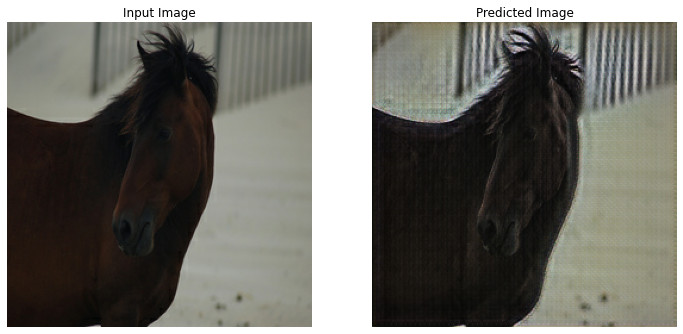

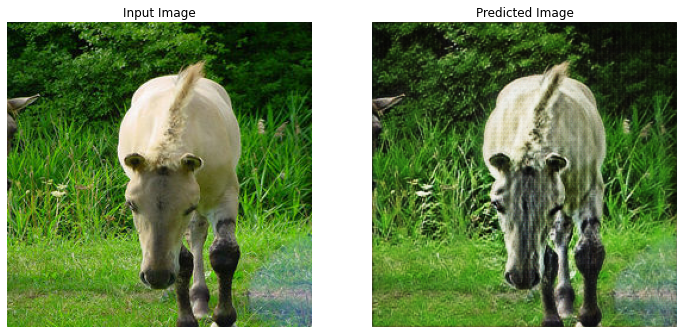

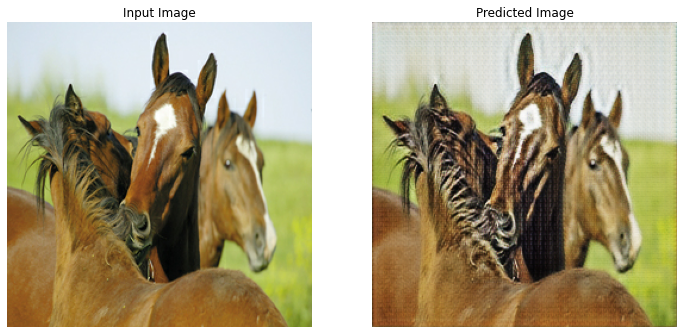

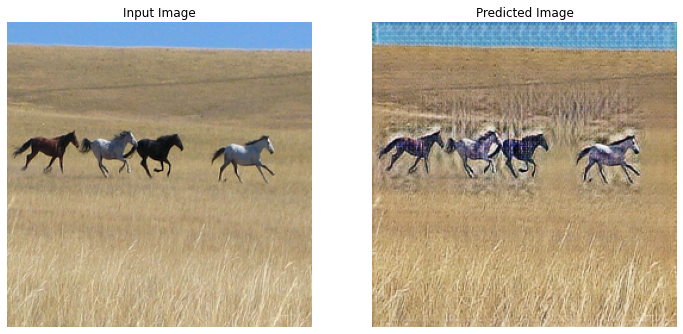

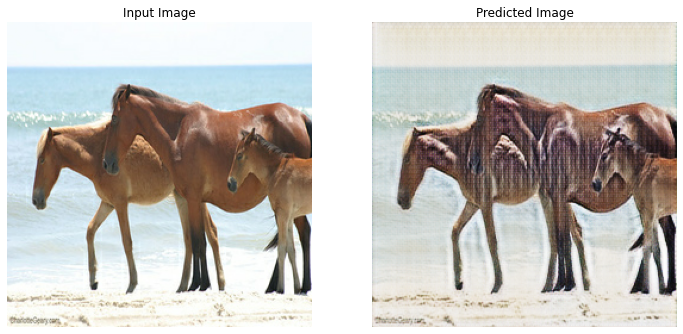

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_horse_to_zebra, inp)


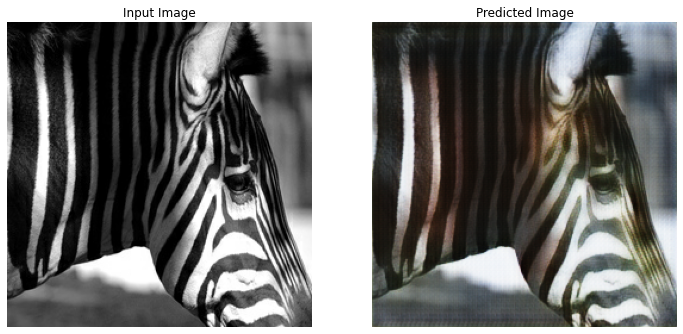

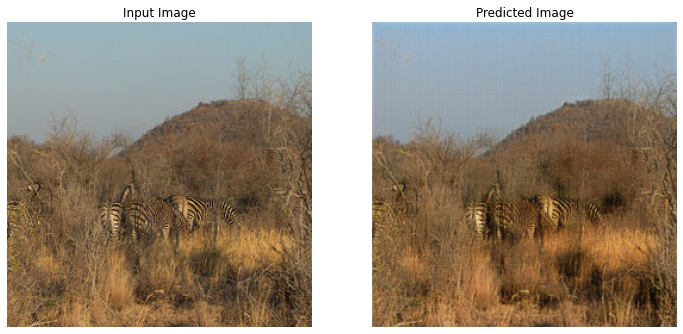

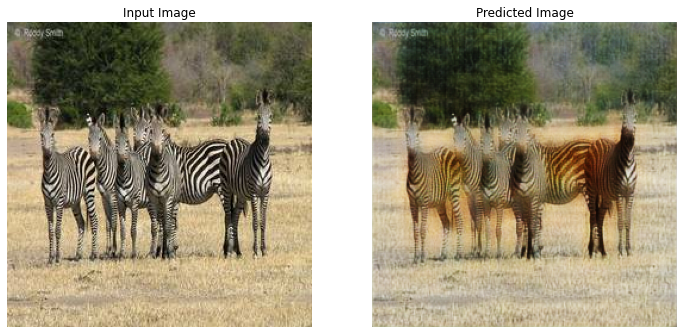

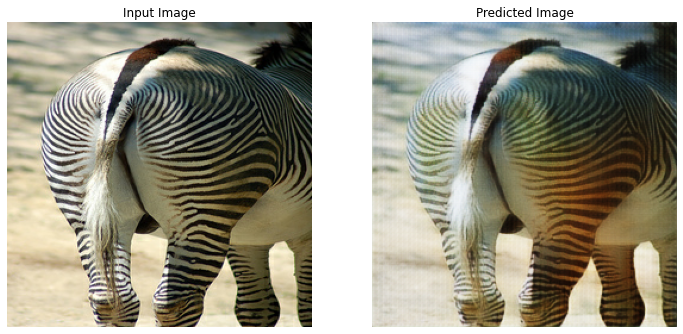

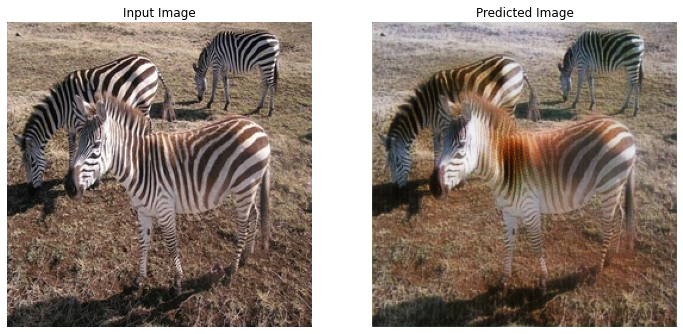

In [ ]:
# Run the trained model on the test dataset
for inp in test_zebras.take(5):
  generate_images(generator_zebra_to_horse, inp)

In [ ]:
to_zebra = generator_horse_to_zebra(sample_horse)
to_horse = generator_zebra_to_horse(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_zebra(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_horse(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

2. Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

### YOLO (You Only Look Once)

YOLO – это передовая сеть для распознавания объектов (object detection), разработанная Джозефом Редмоном (Joseph Redmon). Главное, что отличает ее от других популярных архитектур – это скорость. Модели семейства YOLO действительно быстрые, намного быстрее R-CNN и других. Это значит, что мы можем распознавать объекты в реальном времени.

In [2]:
from IPython.display import Image

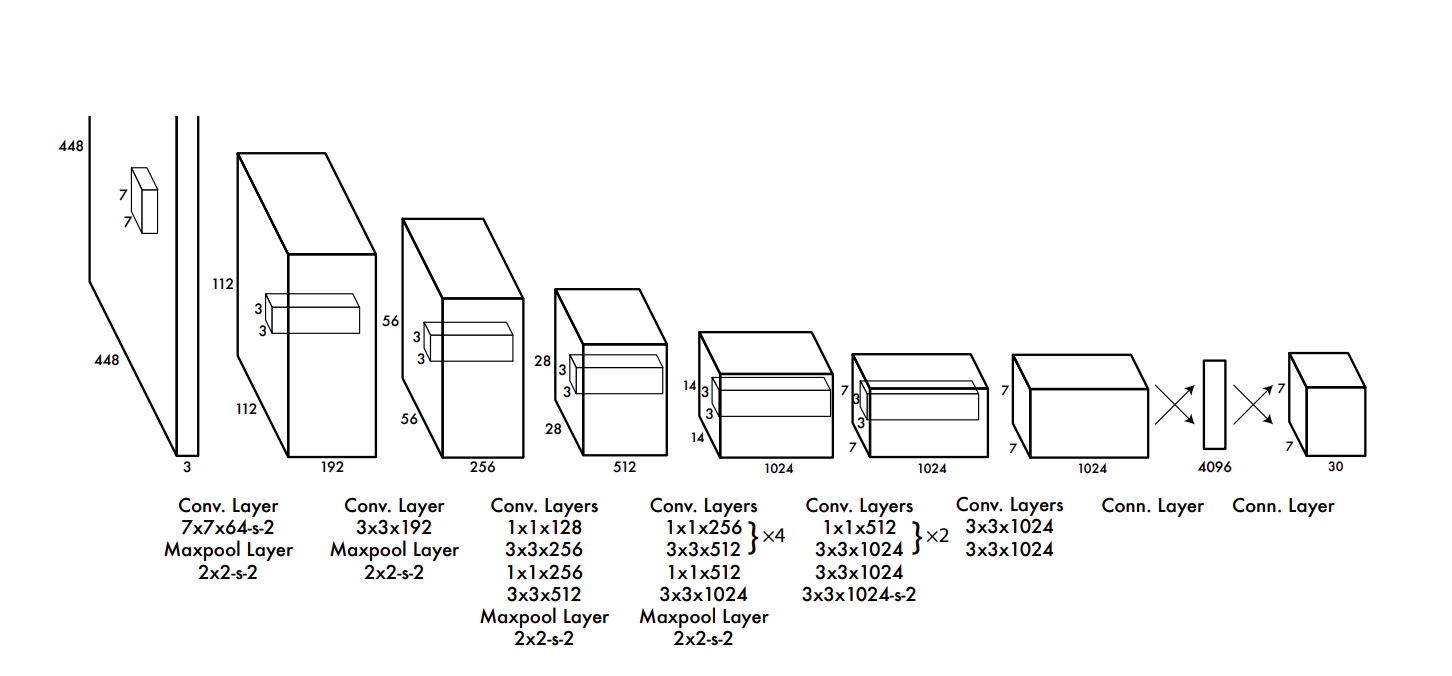

In [3]:
Image("yolo2.jpeg")

Во время первой публикации (в 2016 году) YOLO имела передовую mAP (mean Average Precision), по сравнению с такими системами, как R-CNN и DPM. С другой стороны, YOLO с трудом локализует объекты точно. Тем не менее, она обучается общему представлению объектов. В новой версии как скорость, так и точность системы были улучшены.

Другие подходы в основном использовали метод плавающего над изображением окна, и классификатора для этих регионов (DPM – deformable part models). Кроме этого, R-CNN использовал метод предложения регионов (region proposal). Этот метод сначала генерировал потенциальные содержащие рамки, после чего для них вызывался классификатор, а потом производилась пост-обработка для удаления двойных распознаваний и усовершенствования содержащих рамок.  
YOLO преобразовала задачу распознавания объектов к единой задаче регрессии. Она проходит прямо от пикселей изображения до координат содержащих рамок и вероятностей классов. Таким образом, единая CNN предсказывает множество содержащих рамок и вероятности классов для этих рамок.

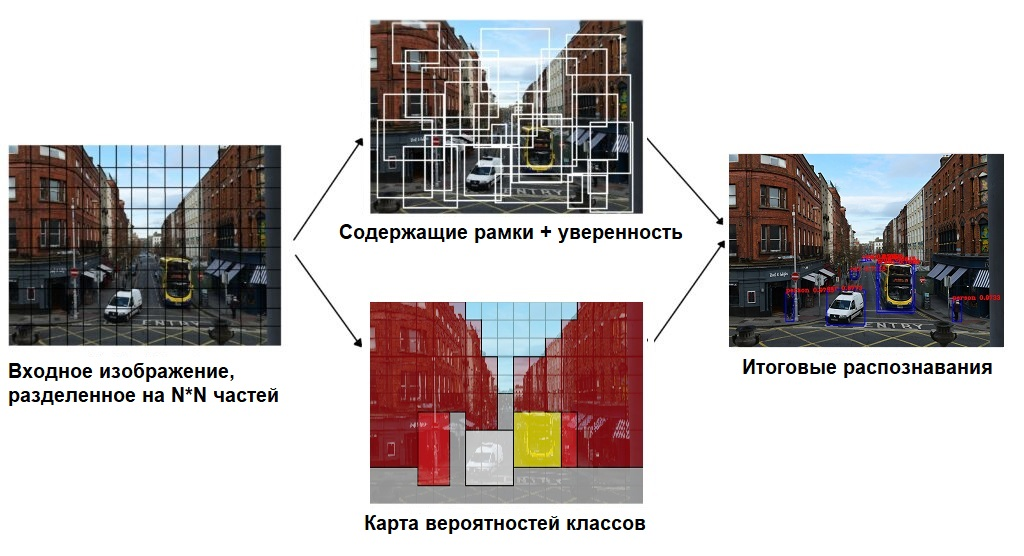

In [4]:
Image("yolo1.jpg")

Плюсы данного подхода состоит в том, что сеть смотрит на все изображение сразу и учитывает контекст при детектировании и распознавании объекта. Так же YOLO в 1000 раз быстрее чем R-CNN и около 100x быстрее чем Fast R-CNN.

### Анализ достоинств и недостатков:
**Преимущества:**

Быстрый, простой трубопровод, низкий уровень ложного обнаружения фона, универсальность.

Частота обнаружения YOLO V3 для неестественных объектов изображения намного выше, чем в методах обнаружения серий DPM и RCNN. Но по сравнению с методами обнаружения объектов серии RCNN, YOLO V3 имеет следующие недостатки:

**Недостатки:**

Точность определения местоположения объекта низкая, а скорость повторного вызова низкая.

Метод прогнозирования для прогнозирования двух bbox в каждой сетке уменьшает количество обнаружений одной и той же цели (метод предложения региона, используемый R-CNN, перекрывается больше), по сравнению с R-CNN, использующим селективный поиск для генерации 2000 предложений. В тесте RCNN каждая фотография превышает 40 секунд), YOLO использует только 7x7x2.

Также сеть YOLO испытывает трудности при обнаружении объектов достаточно небольшого размера